# Optimization for Training Deep Models

Deep learning algorithms involve optimization in many contexts. For example,performing inference in models such as PCA involves solving an optimizationproblem. We often use analytical optimization to write proofs or design algorithms.Of all the many optimization problems involved in deep learning, the most diﬃcultis neural network training.

It is quite common to invest days to months of time onhundreds of machines to solve even a single instance of the neural network trainingproblem. Because this problem is so important and so expensive, a specializedset of optimization techniques have been developed for solving it. This chapterpresents these optimization techniques for neural network training.

We will focus on one particular case of optimization: ﬁnding the parameters $\theta$ of a neural network that signiﬁcantly reduce a cost function $J(\theta)$, which typically includes a performance measure evaluated on the entire training set as well as additional regularization terms.

## How Learning Differs from Pure Optimization?

In most machine learning scenarios, we care about some performance measure $P$, that is deﬁned with respect to the test set. We therefore optimize $P$ only indirectly. We reduce a diﬀerent cost function $J(\theta)$ in the hope that doing so will improve $P$. This is in contrast to pure optimization,where minimizing $J$ is a goal in and of itself. Optimization algorithms for training deep models also typically include some specialization on the speciﬁc structure of machine learning objective functions. This function can be written as an average over the training set:

$$
J(\theta) = E_{(x,y)\sim \hat{P}_{data}} L(f(x;\theta), y)
$$

where $L$ is the per-example loss function,$f(x;θ)$ is the predicted output when the input is $x$, and $\hat{P}_{data}$ the empirical distribution. In the supervised learning case, $y$ is the target output. 

We would usually prefer to minimize the corresponding objective function where the expectation is taken across the data-generating distribution $P_{data}$ rather than just over the ﬁnite training set:

$$
J^*(\theta) = E_{(x,y)\sim P_{data}} L(f(x;\theta), y)
$$

### Empirical Risk Minimization

The goal of a machine learning algorithm is to reduce the expected generalization error. This quantity is known as the **risk**. We emphasize here that the expectation is taken over the true underlying distribution $P_{data}$. If we knew the true distribution $P_{data}(x, y)$, risk minimization would be an optimization task solvable by an optimization algorithm. When we do not know $P_{data}(x, y)$ but only have a training set of samples, however, we have a machine learning problem.

The simplest way to convert a machine learning problem back into an optimization problem is to minimize the expected loss on the training set. This means replacing the true distribution $p(x, y)$ with the empirical distribution $\hat{P}_{data}(x, y)$ deﬁned by the training set. We now minimize the **empirical risk**

$$
E_{(x,y)\sim \hat{P}_{data}} L(f(x;\theta), y) = \frac{1}{m}\sum_{i=1}^m L(f(x^{(i)};\theta), y^{(i)})  
$$

where $m$ is the number of training examples. The training process based on minimizing this average training error is known as **empirical risk minimization**. Nonetheless, empirical risk minimization is prone to overﬁtting. Models withhigh capacity can simply memorize the training set. In many cases, empiricalrisk minimization is not really feasible. The most eﬀective modern optimizationalgorithms are based on gradient descent, but many useful loss functions, suchas 0-1 loss, have no useful derivatives (the derivative is either zero or undeﬁnedeverywhere). These two problems mean that, in the context of deep learning, werarely use empirical risk minimization. Instead, we must use a slightly diﬀerentapproach, in which the quantity that we actually optimize is even more diﬀerentfrom the quantity that we truly want to optimize

### Surrogate Loss Functions and Early Stopping

Sometimes, the loss function we actually care about (say, classiﬁcation error) is notone that can be optimized eﬃciently. For example, exactly minimizing expected 0-1loss is typically intractable (exponential in the input dimension). In such situations, one typically optimizes a surrogate loss function instead. 

### Batch and Minibatch Algorithms

One aspect of machine learning algorithms that separates them from generaloptimization algorithms is that the objective function usually decomposes as a sumover the training examples. Optimization algorithms for machine learning typically compute each update to the parameters based on an expected value of the costfunction estimated using only a subset of the terms of the full cost function. For example maximum likelihood estimation problems when viewed in logspace, decompose into a sum over each example:

$$
\theta_{ML} \argmax_{\theta} \sum_{i=1}^m log P_{model}(x^{(i)}, y^{(i)}; \theta) 
$$

Maximizing this sum is equivalent to maximizing the expectation over theempirical distribution deﬁned by the training set:

$$
J(\theta) = E_{x,y\sim \hat{P}_{data}} log P_{model}(x,y;\theta)
$$

Most of the properties of the objective function $J$ used by most of our optimization algorithms are also expectations over the training set. For example, the most commonly used property is the gradient:

$$
\nabla_{\theta}J(\theta) = E_{x,y\sim \hat{P}_{data}} \nabla_\theta log P_{model}(x,y;\theta)
$$

Computing this expectation exactly is very expensive because it requiresevaluating the model on every example in the entire dataset. In practice, we cancompute these expectations by randomly sampling a small number of examplesfrom the dataset, then taking the average over only those examples.

Challenges in Neural Network Optimization include
- **Ill-Conditioning**: Ill-conditioning can manifest by causing SGD to get“stuck” in the sense that even very small steps increase the cost function.

- **Local Minima**: With nonconvex functions, such as neural nets, it is possible to have manylocal minima. Indeed, nearly any deep model is essentially guaranteed to havean extremely large number of local minima.

- **Plateaus, Saddle Points and Other Flat Regions**: In low-dimensional spaces, local minima are common. In higher-dimensional spaces, localminima are rare, and saddle points are more common.

- **Cliﬀs and Exploding Gradients**: On the face of an extremely steep cliﬀ structure, thegradient update step can move the parameters extremely far, usually jumping oﬀthe cliﬀ structure altogether.

- **Long-Term Dependencies**: Another diﬃculty that neural network optimization algorithms must overcomearises when the computational graph becomes extremely deep. Feedforwardnetworks with many layers have such deep computational graphs.

- **Inexact Gradients**: Most optimization algorithms are designed with the assumption that we haveaccess to the exact gradient or Hessian matrix. In practice, we usually have onlya noisy or even biased estimate of these quantities. Nearly every deep learningalgorithm relies on sampling-based estimates, at least insofar as using a minibatchof training examples to compute the gradient.

- **Poor Correspondence between Local and Global Structure**: Many of the problems we have discussed so far correspond to properties of the loss function at a single point—it can be diﬃcult to make a single step if $J(\theta)$ is poorly conditioned at the current point $\theta$, or if $\theta$ lies on a cliff, or if $\theta$ is a saddlepoint hiding the opportunity to make progress downhill from the gradient.

- **Theoretical Limits of Optimization**: Some theoretical results showthat there exist problem classes that are intractable, but it can be diﬃcult to tellwhether a particular problem falls into that class. Other results show that ﬁndinga solution for a network of a given size is intractable, but in practice we can ﬁnd asolution easily by using a larger network for which many more parameter settingscorrespond to an acceptable solution.

## Basic Algorithms

### Stochastic Gradient Descent

Stochastic gradient descent (SGD) and its variants are probably the most usedoptimization algorithms for machine learning in general and for deep learningin particular. It is possible to obtain an unbiasedestimate of the gradient by taking the average gradient on a minibatch ofmexamples drawn i.i.d from the data-generating distribution

A crucial parameter for the SGD algorithm is the learning rate. Previously, wehave described SGD as using a ﬁxed learning rate $\epsilon$. In practice, it is necessary togradually decrease the learning rate over time, so we now denote the learning rateat iteration $k$ as $\epsilon_k$. This is because the SGD gradient estimator introduces a source of noise (the random sampling of $m$ training examples) that does not vanish even when we arriveat a minimum. By comparison, the true gradient of the total cost function becomessmall and then0when we approach and reach a minimum using batch gradient descent, so batch gradient descent can use a ﬁxed learning rate. A suﬃcient condition to guarantee convergence of SGD is that

$$
\sum_{k=1}^\infty \epsilon_k = \infty
$$

$$
\sum_{k=1}^\infty \epsilon_k^2 < \infty
$$

In practice, it is common to decay the learning rate linearly until iteration $\tau$:

$$
\epsilon_k = (1-\alpha)\epsilon_0 + \alpha\epsilon_{\tau}
$$

with $\alpha = \frac{k}{\tau}$. After iteration $\tau$ , it is common to leave $\epsilon$ constant. The learning rate may be chosen by trial and error, but it is usually best to choose it by monitoring learning curves that plot the objective function as a function of time. This is more of an art than a science, and most guidance on thissubject should be regarded with some skepticism.

Algorithm: Stochastic gradient descent (SGD) update

Require: Learning rate schedule $\epsilon_1, \epsilon_2,...$

Require: Initial parameter $\theta$

- k $\leftarrow$ 1
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i}$
    - Compute gradiet estimate: $\hat{g}\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)})$
    - Apply update: $\theta \leftarrow \theta -\epsilon_k\hat{g}$
    - $k\leftarrow k+1$
- end while


### Momentum

While stochastic gradient descent remains a popular optimization strategy, learning with it can sometimes be slow. The method of momentum is designed to accelerate learning, especially in the face of high curvature, small butconsistent gradients, or noisy gradients. The momentum algorithm accumulates an exponentially decaying moving average of past gradients and continues to move in their direction.

<img src="img\download.png" width="30%" height="30%">

Formally, the momentum algorithm introduces a variable $v$ that plays the role of velocity—it is the direction and speed at which the parameters move through parameter space. The velocity is set to an exponentially decaying average of the negative gradient. A hyperparameter $\alpha \in [0,1)$ determines how quickly the contributions of previous gradients exponentially decay.The update rule is given by

$$
v \leftarrow \alpha v - \epsilon\nabla_\theta \left( \frac{1}{m}\sum_{i=1}^m L(f(x^{(i)};\theta), y^{(i)})\right)
$$

$$
\theta \leftarrow \theta + v
$$

Algorithm: Stochastic gradient descent (SGD) with momentum

Require: Learning rate $\epsilon$, momentum parameter $\alpha$

Require: Initial parameter $\theta$, initial velocity $v$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i}$
    - Compute gradiet estimate: $\hat{g}\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)})$
    - Compute velocity update: $v\leftarrow \alpha v - \epsilon g$
    - Apply update: $\theta \leftarrow \theta + v$
- end while

Previously, the size of the step was simply the norm of the gradient multipliedby the learning rate. Now, the size of the step depends on how large and howaligned a sequence of gradients are. The step size is largest when many successivegradients point in exactly the same direction.

It is thus helpful to think of the momentum hyperparameter in terms of $\frac{1}{1−\alpha}$. For example, $\alpha = 0.9$ corresponds to multiplying the maximum speed by 10 relative tothe gradient descent algorithm.

Common values ofαused in practice include 0.5, 0.9, and 0.99. Like thelearning rate, $\alpha$ may also be adapted over time. Typically it begins with a small value and is later raised. Adapting $\alpha$ over time is less important than shrinking $\epsilon$ over time.

### Nesterov Momentum

With Nesterov momentum, the gradient isevaluated after the current velocity is applied. Thus one can interpret Nesterovmomentum as attempting to add a correction factor to the standard methodof momentum.

Algorithm: Stochastic gradient descent (SGD) with Nesterov's momentum

Require: Learning rate $\epsilon$, momentum parameter $\alpha$

Require: Initial parameter $\theta$, initial velocity $v$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i}$
    - Apply interim update:  $\tilde{\theta}\leftarrow \theta+\alpha v$
    - Compute gradiet estimate: $\hat{g}\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\tilde{\theta}), y^{(i)})$
    - Compute velocity update: $v\leftarrow \alpha v - \epsilon g$
    - Apply update: $\theta \leftarrow \theta + v$
- end while

### Algorithms with Adaptive Learning Rates

Neural network researchers have long realized that the learning rate is reliablyone of the most diﬃcult to set hyperparameters because it signiﬁcantly affects model performance. The cost is often highly sensitive to some directions in parameter space and insensitive to others. Themomentum algorithm can mitigate these issues somewhat, but it does so at theexpense of introducing another hyperparameter.

If we believe that the directions of sensitivity aresomewhat axis aligned, it can make sense to use a separate learning rate for eachparameter and automatically adapt these learning rates throughout the course oflearning.

More recently, a number of incremental (or mini batch-based) methods havebeen introduced that adapt the learning rates of model parameters. In this section,we brieﬂy review a few of these algorithms

### Algorithm: The AdaGrad algorithm

Require: Global Learning rate $\epsilon$

Require: Initial parameter $\theta$

Require: Small constant $\delta$, perhaps $10^{-7}$, for numerical stability
- Initialize gradient accumulation variable $r=0$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i)}$
    - Compute gradient: $g\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)})$
    - Accumulate squared gradient: $r \leftarrow r + g \odot g$.
    - Compute update: $\Delta\theta \leftarrow -\frac{\epsilon}{\delta+\sqrt
    {r}}\odot g$ (Division and square root applied element-wise)
    - Apply update: $\theta \leftarrow \theta + \Delta\theta$
- end while

### Algorithm: The RMSProp algorithm

Require: Global Learning rate $\epsilon$, decay rate $\rho$

Require: Initial parameter $\theta$

Require: Small constant $\delta$, perhaps $10^{-6}$, used to stabalize division by small numbers
- Initialize gradient accumulation variable $r=0$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i)}$
    - Compute gradient: $g\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)})$
    - Accumulate squared gradient: $r \leftarrow \rho r + (1-\rho) g\odot g$.
    - Compute update: $\Delta\theta \leftarrow -\frac{\epsilon}{\delta+\sqrt{r}}\odot g$ (Division and square root applied element-wise)
    - Apply update: $\theta \leftarrow \theta + \Delta\theta$
- end while

### Algorithm: The RMSProp algorithm with Nestrov momentum

Require: Global Learning rate $\epsilon$, decay rate $\rho$

Require: Initial parameter $\theta$

Require: Small constant $\delta$, perhaps $10^{-6}$, used to stabalize division by small numbers
- Initialize gradient accumulation variable $r=0$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i)}$
    - Compute interim update: $\tilde{\theta} \leftarrow \theta + \alpha v$
    - Compute gradient: $g\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\tilde{\theta} ), y^{(i)})$
    - Accumulate gradient: $r \leftarrow \rho r + (1-\rho) g\odot g$.
    - Compute update: $v \leftarrow \alpha v -\frac{\epsilon}{\sqrt{r}}\odot g$ (Division and square root applied element-wise)
    - Apply update: $\theta \leftarrow \theta + v$
- end while

### Algorithm: The Adam algorithm

Require: Step size $\epsilon$ (Suggested default: 0.001)

Require: Exponential decay rates for moment estimates, $\rho_1$ and $\rho_2$ in [0,1).(Suggested defaults: 0.9 and 0.999 respectively)

Require: Small constant $\delta$, used for numerical stabilization (Suggested default: $10^{−8}$)

Require: Initial parameters $\theta$
- Initialize 1st and 2nd moment variables $s = 0$, $r = 0$
- Initialize time step $t = 0$
- **while** stopping criterion not met **do**
    - Sample a minibatch of me examples from the training set $\{x^{(1)},..., x^{(m)}\}$ with corresponding targets $y^{(i)}$
    - Compute gradient: $g\leftarrow \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta ), y^{(i)})$
    - $t\leftarrow t+1$
    - Update biased ﬁrst moment estimate: $s \leftarrow \rho_1s + (1 − \rho_1)g$
    - Update biased second moment estimate: $r \leftarrow \rho_2r + (1 − \rho_2)g \odot g$
    - Correct bias in ﬁrst moment: $\hat{s} \leftarrow \frac{s}{1−\rho^t_1}$
    - Correct bias in second moment: $\hat{r} \leftarrow \frac{r}{1−\rho^t_2}$
    - Compute update: $\Delta \theta = −\epsilon \frac{\hat{s}}{\sqrt{\hat{r}+\delta}}$ (operations applied element-wise)
    - Apply update: $\theta \leftarrow \theta + \Delta\theta$
- end while

<img src="img/121381obtV.gif">
<img src="img/56201contours_evaluation_optimizers.gif">


# Hands-on Optimizers with Python

In [15]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [16]:
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test =  x_test.reshape(x_test.shape[0],28,28,1)

y_train = keras.utils.np_utils.to_categorical(y_train) 
y_test = keras.utils.np_utils.to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /=255

In [17]:
batch_size = 64
num_classes = 10
epochs = 10
input_shape = (28,28,1)

def build_model(optimizer):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer= optimizer, metrics=['accuracy'])
    
    return model

In [20]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']

models_history = {}
for i in optimizers:
    model = build_model(i)
    hist=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test,y_test))
    models_history[i] = hist

Epoch 1/10
938/938 [==============================] - 34s 35ms/step - loss: 2.2782 - accuracy: 0.1459 - val_loss: 2.2228 - val_accuracy: 0.3174
Epoch 2/10
938/938 [==============================] - 40s 43ms/step - loss: 2.1887 - accuracy: 0.3049 - val_loss: 2.1213 - val_accuracy: 0.6197
Epoch 3/10
938/938 [==============================] - 39s 42ms/step - loss: 2.0875 - accuracy: 0.4569 - val_loss: 2.0019 - val_accuracy: 0.7057
Epoch 4/10
938/938 [==============================] - 34s 36ms/step - loss: 1.9704 - accuracy: 0.5544 - val_loss: 1.8638 - val_accuracy: 0.7474
Epoch 5/10
938/938 [==============================] - 33s 35ms/step - loss: 1.8359 - accuracy: 0.6152 - val_loss: 1.7099 - val_accuracy: 0.7736
Epoch 6/10
938/938 [==============================] - 34s 36ms/step - loss: 1.6921 - accuracy: 0.6535 - val_loss: 1.5487 - val_accuracy: 0.7928
Epoch 7/10
938/938 [==============================] - 34s 36ms/step - loss: 1.5433 - accuracy: 0.6831 - val_loss: 1.3900 - val_accuracy:

We have run our model with a batch size of 64 for 10 epochs. After trying the different optimizers, the results we get are pretty interesting. Before analyzing the results, what do you think will be the best optimizer for this dataset?

## Adadelta

- Epoch 1/10 34s 35ms/step - loss: 2.2782 - accuracy: 0.1459 - val_loss: 2.2228 - val_accuracy: 0.3174
- Epoch 2/10 40s 43ms/step - loss: 2.1887 - accuracy: 0.3049 - val_loss: 2.1213 - val_accuracy: 0.6197
- Epoch 3/10 39s 42ms/step - loss: 2.0875 - accuracy: 0.4569 - val_loss: 2.0019 - val_accuracy: 0.7057
- Epoch 4/10 34s 36ms/step - loss: 1.9704 - accuracy: 0.5544 - val_loss: 1.8638 - val_accuracy: 0.7474
- Epoch 5/10 33s 35ms/step - loss: 1.8359 - accuracy: 0.6152 - val_loss: 1.7099 - val_accuracy: 0.7736
- Epoch 6/10 34s 36ms/step - loss: 1.6921 - accuracy: 0.6535 - val_loss: 1.5487 - val_accuracy: 0.7928
- Epoch 7/10 34s 36ms/step - loss: 1.5433 - accuracy: 0.6831 - val_loss: 1.3900 - val_accuracy: 0.8092
- Epoch 8/10 33s 35ms/step - loss: 1.4021 - accuracy: 0.6992 - val_loss: 1.2432 - val_accuracy: 0.8194
- Epoch 9/10 34s 36ms/step - loss: 1.2757 - accuracy: 0.7164 - val_loss: 1.1137 - val_accuracy: 0.8275
- Epoch 10/10 35s 37ms/step - loss: 1.1663 - accuracy: 0.7314 - val_loss: 1.0028 - val_accuracy: 0.8337

## Adagrad

- Epoch 1/10 33s 35ms/step - loss: 1.7035 - accuracy: 0.5212 - val_loss: 0.8946 - val_accuracy: 0.8293
- Epoch 2/10 33s 35ms/step - loss: 0.8019 - accuracy: 0.7735 - val_loss: 0.5032 - val_accuracy: 0.8791
- Epoch 3/10 33s 35ms/step - loss: 0.5975 - accuracy: 0.8243 - val_loss: 0.4045 - val_accuracy: 0.8958
- Epoch 4/10 32s 34ms/step - loss: 0.5146 - accuracy: 0.8468 - val_loss: 0.3573 - val_accuracy: 0.9049
- Epoch 5/10 33s 35ms/step - loss: 0.4658 - accuracy: 0.8624 - val_loss: 0.3273 - val_accuracy: 0.9099
- Epoch 6/10 32s 34ms/step - loss: 0.4346 - accuracy: 0.8717 - val_loss: 0.3056 - val_accuracy: 0.9163
- Epoch 7/10 34s 36ms/step - loss: 0.4090 - accuracy: 0.8789 - val_loss: 0.2895 - val_accuracy: 0.9204
- Epoch 8/10 35s 37ms/step - loss: 0.3884 - accuracy: 0.8852 - val_loss: 0.2753 - val_accuracy: 0.9233
- Epoch 9/10 31s 33ms/step - loss: 0.3723 - accuracy: 0.8892 - val_loss: 0.2633 - val_accuracy: 0.9257
- Epoch 10/10 103s 110ms/step - loss: 0.3609 - accuracy: 0.8935 - val_loss: 0.2535 - val_accuracy: 0.9282

## Adam

- Epoch 1/10 35s 37ms/step - loss: 0.2290 - accuracy: 0.9317 - val_loss: 0.0656 - val_accuracy: 0.9788
- Epoch 2/10 36s 38ms/step - loss: 0.0906 - accuracy: 0.9724 - val_loss: 0.0495 - val_accuracy: 0.9827
- Epoch 3/10 35s 37ms/step - loss: 0.0670 - accuracy: 0.9796 - val_loss: 0.0394 - val_accuracy: 0.9870
- Epoch 4/10 35s 37ms/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 0.0418 - val_accuracy: 0.9865
- Epoch 5/10 36s 38ms/step - loss: 0.0460 - accuracy: 0.9855 - val_loss: 0.0338 - val_accuracy: 0.9884
- Epoch 6/10 33s 35ms/step - loss: 0.0393 - accuracy: 0.9868 - val_loss: 0.0353 - val_accuracy: 0.9886
- Epoch 7/10 34s 36ms/step - loss: 0.0334 - accuracy: 0.9891 - val_loss: 0.0347 - val_accuracy: 0.9892
- Epoch 8/10 35s 37ms/step - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.0323 - val_accuracy: 0.9897
- Epoch 9/10 34s 36ms/step - loss: 0.0260 - accuracy: 0.9911 - val_loss: 0.0331 - val_accuracy: 0.9895
- Epoch 10/10 34s 37ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0330 - val_accuracy: 0.9886

## RMSprop

- Epoch 1/10 40s 41ms/step - loss: 0.2360 - accuracy: 0.9282 - val_loss: 0.0721 - val_accuracy: 0.9777
- Epoch 2/10 38s 41ms/step - loss: 0.0928 - accuracy: 0.9722 - val_loss: 0.0573 - val_accuracy: 0.9810
- Epoch 3/10 38s 41ms/step - loss: 0.0729 - accuracy: 0.9790 - val_loss: 0.0541 - val_accuracy: 0.9828
- Epoch 4/10 39s 41ms/step - loss: 0.0641 - accuracy: 0.9814 - val_loss: 0.0480 - val_accuracy: 0.9857
- Epoch 5/10 39s 41ms/step - loss: 0.0600 - accuracy: 0.9828 - val_loss: 0.0453 - val_accuracy: 0.9862
- Epoch 6/10 68s 72ms/step - loss: 0.0596 - accuracy: 0.9830 - val_loss: 0.0420 - val_accuracy: 0.9874
- Epoch 7/10 47s 50ms/step - loss: 0.0570 - accuracy: 0.9835 - val_loss: 0.0481 - val_accuracy: 0.9856
- Epoch 8/10 44s 47ms/step - loss: 0.0552 - accuracy: 0.9840 - val_loss: 0.0447 - val_accuracy: 0.9870
- Epoch 9/10 41s 43ms/step - loss: 0.0580 - accuracy: 0.9837 - val_loss: 0.0488 - val_accuracy: 0.9869
- Epoch 10/10 41s 43ms/step - loss: 0.0562 - accuracy: 0.9841 - val_loss: 0.0469 - val_accuracy: 0.9860

## SGD

- Epoch 1/10 34s 36ms/step - loss: 0.8495 - accuracy: 0.7438 - val_loss: 0.3122 - val_accuracy: 0.9119
- Epoch 2/10 33s 36ms/step - loss: 0.3903 - accuracy: 0.8814 - val_loss: 0.2336 - val_accuracy: 0.9333
- Epoch 3/10 34s 36ms/step - loss: 0.3161 - accuracy: 0.9040 - val_loss: 0.1938 - val_accuracy: 0.9443
- Epoch 4/10 33s 36ms/step - loss: 0.2748 - accuracy: 0.9183 - val_loss: 0.1687 - val_accuracy: 0.9515
- Epoch 5/10 33s 35ms/step - loss: 0.2467 - accuracy: 0.9244 - val_loss: 0.1492 - val_accuracy: 0.9566
- Epoch 6/10 32s 34ms/step - loss: 0.2263 - accuracy: 0.9315 - val_loss: 0.1367 - val_accuracy: 0.9598
- Epoch 7/10 33s 35ms/step - loss: 0.2123 - accuracy: 0.9357 - val_loss: 0.1279 - val_accuracy: 0.9630
- Epoch 8/10 34s 36ms/step - loss: 0.1982 - accuracy: 0.9405 - val_loss: 0.1189 - val_accuracy: 0.9644
- Epoch 9/10 34s 36ms/step - loss: 0.1896 - accuracy: 0.9430 - val_loss: 0.1144 - val_accuracy: 0.9663
- Epoch 10/10 35s 38ms/step - loss: 0.1796 - accuracy: 0.9463 - val_loss: 0.1078 - val_accuracy: 0.9681


## Table Analysis
The above table shows the validation accuracy and loss at different epochs. It also contains the total time that the model took to run on 10 epochs for each optimizer. From the above table, we can make the following analysis.

- The adam optimizer shows the best accuracy in a satisfactory amount of time.
- RMSprop shows similar accuracy to that of Adam but with a comparatively much larger computation time.
- Surprisingly, the SGD algorithm took the least time to train and produced good results as well. But to reach the accuracy of the Adam optimizer, SGD will require more iterations, and hence the computation time will increase.
- SGD with momentum shows similar accuracy to SGD with unexpectedly larger computation time. This means the value of momentum taken needs to be optimized.
- Adadelta shows poor results both with accuracy and relative computation time (before final epoch).

You can analyze the accuracy of each optimizer with each epoch from the below graph.

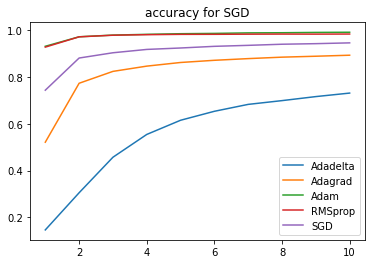

In [35]:
import matplotlib.pyplot as plt


x_axis = [num+1 for num in range(10)]
for optimizer in models_history:
    optimizer_model = models_history[optimizer]
    y_axis = optimizer_model.history['accuracy']
    plt.plot(x_axis, y_axis, label=optimizer)
plt.title('accuracy for ' +optimizer)
plt.legend()
plt.show()

## Summary
SGD is a very basic algorithm and is hardly used in applications now due to its slow computation speed. One more problem with that algorithm is the constant learning rate for every epoch. Moreover, it is not able to handle saddle points very well. Adagrad works better than stochastic gradient descent generally due to frequent updates in the learning rate. It is best when used for dealing with sparse data. RMSProp shows similar results to that of the gradient descent algorithm with momentum, it just differs in the way by which the gradients are calculated.

Lastly comes the Adam optimizer that inherits the good features of RMSProp and other algorithms. The results of the Adam optimizer are generally better than every other optimization algorithm, have faster computation time, and require fewer parameters for tuning. Because of all that, Adam is recommended as the default optimizer for most of the applications. Choosing the Adam optimizer for your application might give you the best probability of getting the best results.

But by the end, we learned that even Adam optimizer has some downsides. Also, there are cases when algorithms like SGD might be beneficial and perform better than Adam optimizer. So, it is of utmost importance to know your requirements and the type of data you are dealing with to choose the best optimization algorithm and achieve outstanding results.

### Conclusion
This article taught us how an optimization algorithm could affect the deep learning model in terms of accuracy, speed, and efficiency. We learned about various algorithms, and hopefully, you were able to compare the algorithms with one another. We also learned when to use which algorithm and what could be the downsides of using that algorithm.

**Key Takeaways**

- Gradient Descent, Stochastic Gradient Descent, Mini-batch Gradient Descent, Adagrad, RMS Prop, AdaDelta, and Adam are all popular deep-learning optimizers.
- Each optimizer has its own strengths and weaknesses, and the choice of optimizer will depend on the specific deep-learning task and the characteristics of the data being used.
- The choice of optimizer can significantly impact the speed and quality of convergence during training, as well as the final performance of the deep learning model.